In [68]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [153]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1

        
    def __sub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        self.grad = 1.0
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value({self.label if self.label != '' else 'data'}={self.data})"


In [154]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [155]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(-1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1w1x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

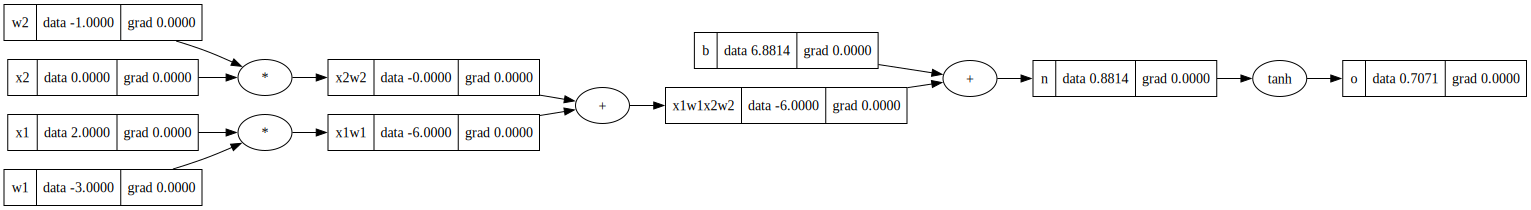

In [156]:
draw_dot(o)

In [157]:
o.backward()

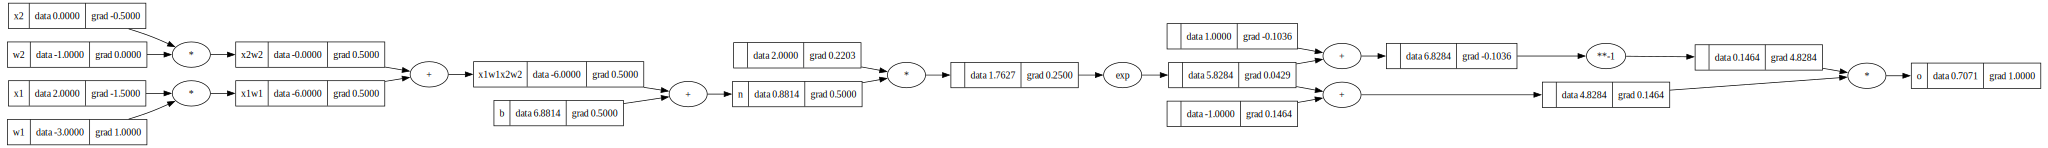

In [158]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(-1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1w1x2w2"
n = x1w1x2w2 + b; n.label="n"


e = (2*n).exp()

o = (e - 1) / (e + 1)

o.label="o"

o.backward()

draw_dot(o)